## LeGac: Modelling real strong lensing systems from the SuGOHI-V survey 

![](https://www.gov.br/cbpf/pt-br/assuntos/noticias/inscricao-para-duas-bolsas-pibic-ate-terca-09/cbpf-1.png/@@images/80c1e3d4-b426-4237-ad44-6e2039b64eef.png)


João Paulo Correia de França

E-mail: joaofranca@cbpf.br/joao.contato505@gmail.com

Data access: github.com/CosmoObs/legac_2022/AutoLensModelling




In [ ]:
# The place where we are about to perform the modelling
workspace_path = '/content/drive/MyDrive/legac_data/'

%cd $workspace_path

/content/drive/MyDrive/legac_data


In [ ]:
# Keep in mind that your path should have, at least: the system path (233106+000012/, for example); config (autolens config files) and sugohi_select.csv (csv database)
%ls

233106+000012/  config/  output/  root.log  sugohi_select.csv


In [ ]:
# installing the version 2022.7.11.1 of autolens. You may be asked to restart the kernel
!pip3 install autolens==2022.7.11.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# A few basic imports
import pandas as pd
import numpy as np

# Magic function to allow displayed graphs
%matplotlib inline

In [ ]:
# Csv database
sugohi_select = pd.read_csv('./sugohi_select.csv')
sugohi_select.head()

,idx,participant,JNAME,z_L,z_S,positions
0,0,Carlos,J000848+001550,0.396703,0.890,"(45.495464, 56.348639); (67.201814, 61)"
1,1,Clécio,J015938-035859,1.110000,1.650,"(67.791046, 59.008803); (52.487411, 53.965707)"
2,2,Cristina,J023249-032326,0.450000,2.518,"(65.349186, 79.287481); (37.622687, 61.337385)..."
3,3,Damián,J083930+021024,0.740000,0.980,"(71.844233, 58.371178); (54.201408, 60.893688)..."
4,5,Davi,J101847-012132,0.388379,1.130,"(77.625183, 63.84833); (66.367601, 42.517895);..."


In [ ]:
# Selecting our system. Here we used the name column...
sugohi_select = sugohi_select[sugohi_select['participant']=='João']
sugohi_select

,idx,participant,JNAME,z_L,z_S,positions
12,14,João,J233106+000012,0.61,0.89,"(55.093602, 64.894328); (61.112157, 65.149796)..."


In [ ]:
# ... but you can also use the JNAME if you want
#sugohi_select = sugohi_select[sugohi_select['JNAME']=='J233106+000012']
#sugohi_select

,idx,participant,JNAME,z_L,z_S,positions
12,14,João,J233106+000012,0.61,0.89,"(55.093602, 64.894328); (61.112157, 65.149796)..."


In [ ]:
# Import our main, module
import autolens as al

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [ ]:
# System path
path = './233106+000012/'
# Pixel to arcseconds conversion factor
pixel_scales = 20/120

# Basic structure to read a fits file
image = al.Array2D.from_fits(file_path=path+'image.fits', pixel_scales=pixel_scales, hdu=0) # if your array is empty, please check the hdu parameter
noise_map = al.Array2D.from_fits(file_path=path+'noise_map.fits', pixel_scales=pixel_scales, hdu=0) 
psf = al.Kernel2D.from_fits(file_path=path+'psf.fits', hdu=0, pixel_scales=pixel_scales, normalize=True) # PSF kernel

In [ ]:
# AutoLens plot package (similar to plt, from matplotlib.pyplot...)
import autolens.plot as aplt

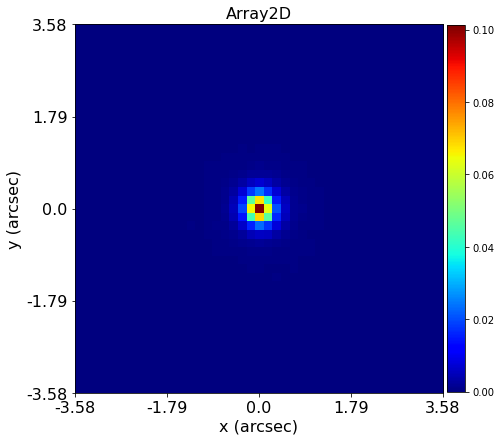

In [ ]:
# Basic structure for plots
visuals_2d = aplt.Visuals2D()
array_plotter = aplt.Array2DPlotter(array=psf, visuals_2d=visuals_2d) # if you want to see the image or noise map, you can use array=image or array=noise_map
array_plotter.figure_2d()

In [ ]:
# Lets resize our psf kernel
psf = al.preprocess.array_with_new_shape(array=psf, new_shape=(17, 17))

In [ ]:
# Imaging object, 
imaging = al.Imaging(image=image, noise_map=noise_map, psf=psf)

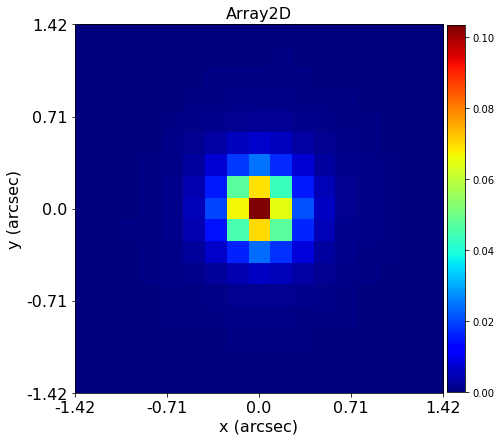

In [ ]:
# Same plot structure, but now we plot using an imaging attribute imaging.image, imaging.noise_map, imaging.psf
visuals_2d = aplt.Visuals2D()
array_plotter = aplt.Array2DPlotter(array=imaging.psf, visuals_2d=visuals_2d)
array_plotter.figure_2d()

In [ ]:
# Bad-Pixel mask available in the path
mask = al.Mask2D.from_fits(file_path=path+'mask.fits', pixel_scales=pixel_scales)
# Circular mask to avoid psf convolution in the image borders
circ_mask = al.Mask2D.circular(shape_native=image.shape_native, pixel_scales=pixel_scales, radius=4.)
# Combining the masks
final_mask = mask + circ_mask

In [ ]:
# Applying the final mask to our imaging object
imaging = imaging.apply_mask(mask=final_mask)

2022-08-13 20:54:01,473 - autoarray.dataset.imaging - INFO - IMAGING - Data masked, contains a total of 1529 image-pixels


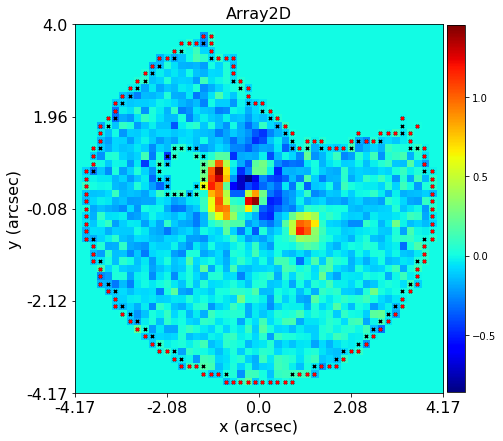

In [ ]:
# Masking visualization in the image attribute
visuals_2d = aplt.Visuals2D()
array_plotter = aplt.Array2DPlotter(array=imaging.image, visuals_2d=visuals_2d)
array_plotter.figure_2d()

In [ ]:
# Lens and source redshifts available in the dataset
zl = float(sugohi_select['z_L'])
zs = float(sugohi_select['z_S'])

In [ ]:
print(zl, zs)

0.61 0.89


In [ ]:
# AutoFit is a package that manage models and optimizers, but dont worry, PyAutoLens have already installed throught dependency
import autofit as af

In [ ]:
# Source galaxy model
source_galaxy_model = af.Model(al.Galaxy,
                               redshift=zs, # source redshift
                               bulge=al.lmp.EllSersic) # Sersic light profile (parametric)
# Lens galaxy model
lens_galaxy_model = af.Model(al.Galaxy,
                             redshift=zl, # lens redshift
                             mass=al.mp.EllIsothermal, # SIE mass profile
                             shear=al.mp.ExternalShear) # Shear component 

In [ ]:
# Gaussian priors to elliptical components
lens_galaxy_model.mass.elliptical_comps.elliptical_comps_0 = af.GaussianPrior(mean=0, sigma=0.2)
lens_galaxy_model.mass.elliptical_comps.elliptical_comps_1 = af.GaussianPrior(mean=0, sigma=0.2)

source_galaxy_model.bulge.elliptical_comps.elliptical_comps_0 = af.GaussianPrior(mean=0, sigma=0.2)
source_galaxy_model.bulge.elliptical_comps.elliptical_comps_1 = af.GaussianPrior(mean=0, sigma=0.2)

In [ ]:
# Model collection
model_0 = af.Collection(galaxies=af.Collection(lens=lens_galaxy_model, source=source_galaxy_model))

In [ ]:
# Multiple images peak positions
list(sugohi_select['positions'])

['(55.093602, 64.894328); (61.112157, 65.149796); (54.898886, 59.961512); (66.006673, 56.96236)']

In [ ]:
# Lets create a position object. Note that our image is a 120x120 pixel (we use the half value to convert to centered arcsec coordinates)
positions = al.Grid2DIrregular(
    grid=[((64.894328-60.5)*pixel_scales, (55.093602-60.5)*pixel_scales),
          ((65.149796-60.5)*pixel_scales, (61.112157-60.5)*pixel_scales),
          ((59.961512-60.5)*pixel_scales, (54.898886-60.5)*pixel_scales),
          ((56.96236-60.5)*pixel_scales, (66.006673-60.5)*pixel_scales)]
)

In [ ]:
# Positioning object penalty, threshold value dictates at which moment we will penalize (in unit of arcsec)
positions_likelihood = al.PositionsLHPenalty(positions=positions, threshold=0.3)

In [ ]:
# Optimizer structure
search_0 = af.DynestyStatic(path_prefix = './', # path-prefix path of our results
                          name = '0', # subfolder path
                          unique_tag = '233106+000012', # main folder path
                          nlive = 50,
                          number_of_cores = 2) 
analysis_0 = al.AnalysisImaging(dataset=imaging, positions_likelihood=positions_likelihood)  # analysis object 
result_0 = search_0.fit(model=model_0, analysis=analysis_0) # result object

2022-08-13 20:54:08,427 - autofit.non_linear.abstract_search - INFO - Creating search
2022-08-13 20:54:08,434 - 0 - INFO - Starting search
2022-08-13 20:54:12,496 - 0 - INFO - Already completed, skipping non-linear search.
2022-08-13 20:54:16,987 - 0 - INFO - Removing zip file


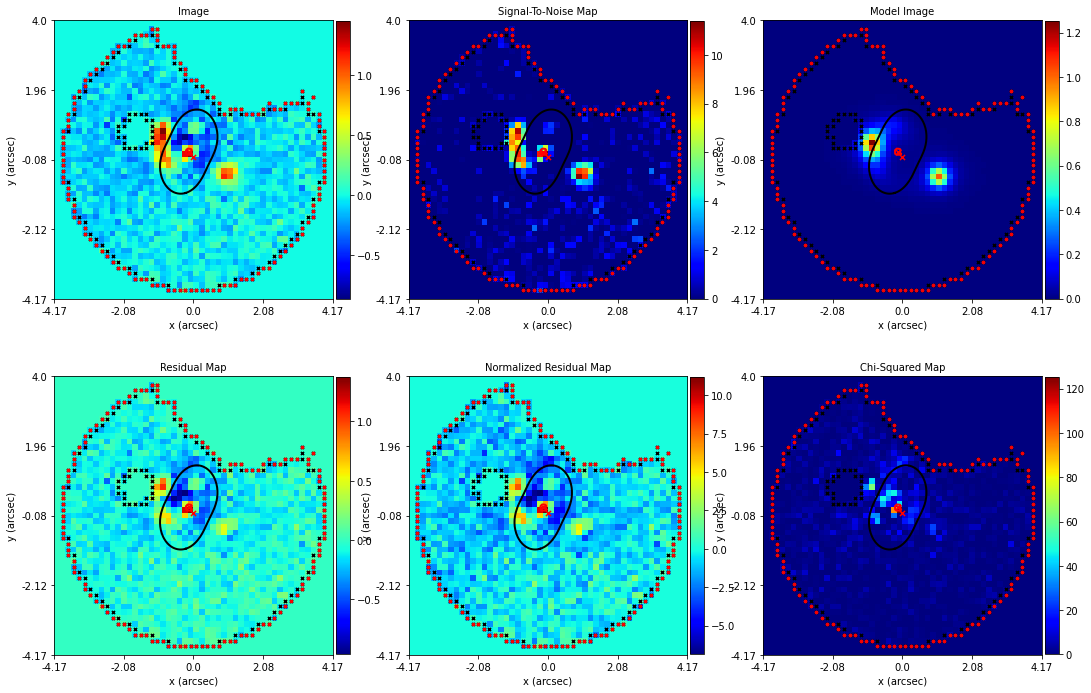

In [ ]:
# Basic structure for results visualizations
fit_imaging_plotter = aplt.FitImagingPlotter(fit=result_0.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

In [ ]:
# You can also get the model image using the following result instance
model_image = result_0.unmasked_model_image

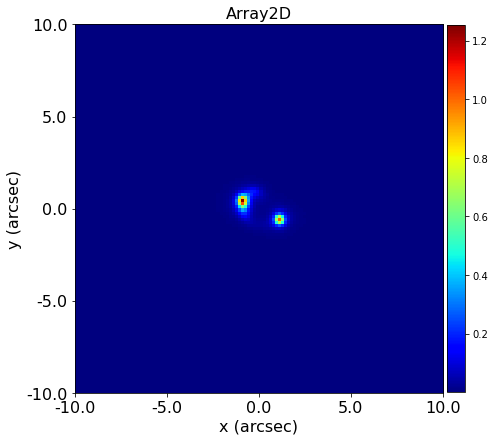

In [ ]:
# Visualizing our model image
visuals_2d = aplt.Visuals2D()
array_plotter = aplt.Array2DPlotter(array=model_image, visuals_2d=visuals_2d)
array_plotter.figure_2d()

In [ ]:
# Export our model image to the output path created by PyAutoLens
model_image.output_to_fits('./output/sp_model_result.fits', overwrite=True)

In [ ]:
# Now, lets model using an inversion pipeline
source_galaxy_model_1 = af.Model(al.Galaxy,
                                 redshift=zs,
                                 pixelization=al.pix.VoronoiMagnification, # Voronoi magnification based pixelization (MPR)
                                 regularization=al.reg.Constant) # constant regularization

lens_galaxy_model_1 = af.Model(al.Galaxy,
                               redshift=zl,
                               mass=result_0.instance.galaxies.lens.mass, # fixed
                               shear=result_0.instance.galaxies.lens.shear) # fixed

In [ ]:
# Our new model collection (1)
model_1 = af.Collection(galaxies=af.Collection(lens=lens_galaxy_model_1, source=source_galaxy_model_1))

In [ ]:
# Another optimizing structure
search_1 = af.DynestyStatic(path_prefix = './', 
                            name = '1', 
                            unique_tag = '233106+000012',
                            nlive = 30,
                            number_of_cores = 2)

analysis_1 = al.AnalysisImaging(dataset=imaging, positions_likelihood=positions_likelihood)
result_1 = search_1.fit(model=model_1, analysis=analysis_1)

2022-08-13 20:54:22,580 - autofit.non_linear.abstract_search - INFO - Creating search
2022-08-13 20:54:22,591 - 1 - INFO - Starting search
2022-08-13 20:54:25,214 - 1 - INFO - Already completed, skipping non-linear search.
2022-08-13 20:54:25,260 - autoarray.dataset.imaging - INFO - IMAGING - Computing W-Tilde... May take a moment.
2022-08-13 20:54:36,739 - 1 - INFO - Removing zip file


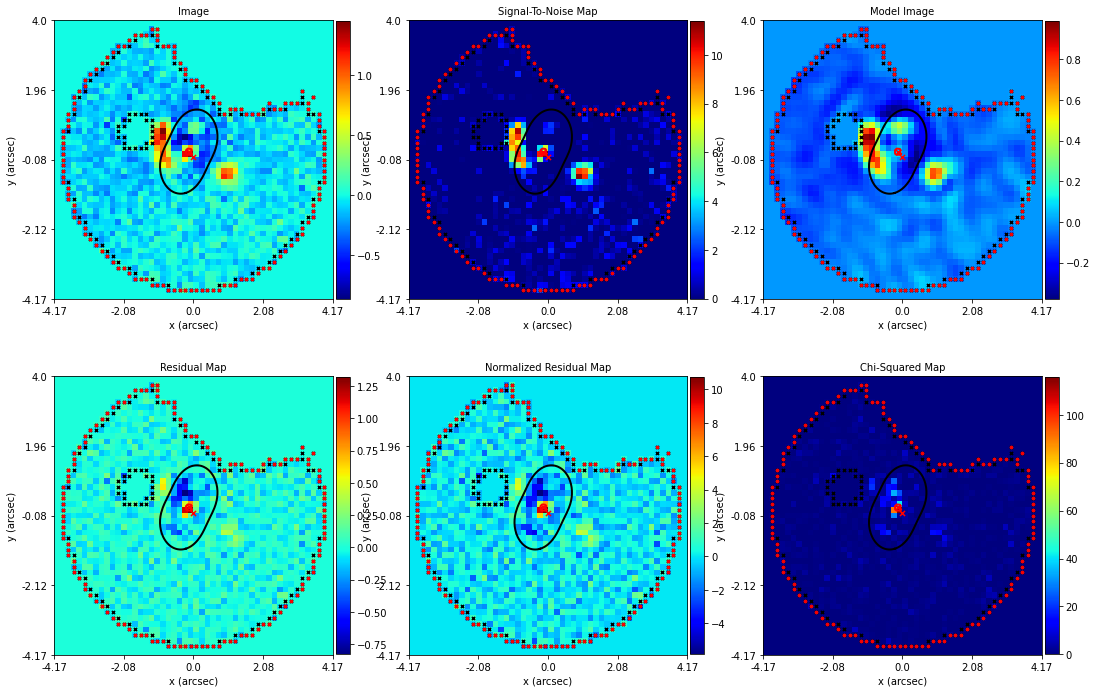

In [ ]:
# Visualizing the inversion modelling results
fit_imaging_plotter = aplt.FitImagingPlotter(fit=result_1.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()